In [1]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import StandardScaler
import matplotlib.pyplot as plt


# 1. EDA

In [2]:
def EDA_data(prop_path, unprop_path, maneuvers_path):

    # Load orbital elements data (propagated and unpropagated)
    prop = pd.read_csv(prop_path, parse_dates=[0], index_col=0)
    unprop = pd.read_csv(unprop_path, parse_dates=[0], index_col=0)
    
    # Sort the time.
    prop = prop.sort_index()
    unprop = unprop.sort_index()

    # Resample to daily frequency, taking the mean
    prop = prop.resample('D').mean()
    unprop = unprop.resample('D').mean()

    # Combine indices to create a complete time range
    all_times = prop.index.union(unprop.index)
    
    # Basic information of the ts datasets
    print("Propagated Data Info:")
    print(prop.info())
    print("\nUnpropagated Data Info:")
    print(unprop.info())
    print("\n" + "="*50 + "\n")

    # Summary statistics
    print("\nPropagated Data Summary Statistics:")
    print(prop.describe())
    print("\nUnpropagated Data Summary Statistics:")
    print(unprop.describe())
    print("\n" + "="*50 + "\n")
    
    # Check for duplicated dates
    print("\nChecking for duplicated dates in 'propagated' dataset index...")
    if prop.index.has_duplicates:
        print("Found duplicated dates in 'propagated' dataset.")
        print(prop.index[prop.index.duplicated()])
    else:
        print("No duplicated dates found in 'propagated' dataset index.")

    print("\nChecking for duplicated dates in 'unpropagated' dataset index...")
    if unprop.index.has_duplicates:
        print("Found duplicated dates in 'unpropagated' dataset.")
        print(unprop.index[unprop.index.duplicated()])
    else:
        print("No duplicated dates found in 'unpropagated' dataset index.")
    print("\n" + "="*50 + "\n")
    
    # Check for dates with NA values after resampling and interpolate if necessary
    missing_prop_dates = prop.index[prop.isnull().any(axis=1)]
    if not missing_prop_dates.empty:
        print("\nDate with missing data in the 'propagated' dataset:")
        print(missing_prop_dates)
        print("Reindexing and interpolating missing values in time...")

        # Reindex and interpolate missing values in time
        prop = prop.reindex(all_times)
        prop = prop.interpolate(method='time')
        print("Missing values interpolated.")
    else:        
        print("No missing dates found in the 'propagated' dataset.")

    
    missing_unprop_dates = unprop.index[unprop.isnull().any(axis=1)]
    if not missing_unprop_dates.empty:
        print("\nDates with missing data in the 'unpropagated' dataset:")
        print(missing_unprop_dates)
        print("Reindexing and interpolating missing values in time...")
        unprop = unprop.reindex(all_times)
        unprop = unprop.interpolate(method='time')
        print("Missing values interpolated.")
    else:
        print("No missing dates found in the 'unpropagated' dataset.")

    print("\n" + "="*50 + "\n")

    # Select elements to compare
    elements = {
        'right ascension': 'RAAN (Ω)',
        'argument of perigee': 'Arg. of Perigee (ω)',
        'mean anomaly': 'Mean Anomaly (M)',
        'eccentricity': 'Eccentricity',
        'inclination': 'Inclination',        
        'Brouwer mean motion': 'Mean Motion (n)'
    }

    # Plot comparisons with maneuvers highlighted
    maneuvers = []
    with open(maneuvers_path, 'r') as f:
        for line in f:
            parts = line.split()
            if len(parts) > 0:
                y1 = int(parts[1]); doy1 = int(parts[2]); h1 = int(parts[3]); m1 = int(parts[4])
                y2 = int(parts[5]); doy2 = int(parts[6]); h2 = int(parts[7]); m2 = int(parts[8])
                start = pd.Timestamp(f"{y1}-01-01") + pd.Timedelta(days=(doy1-1), hours=h1, minutes=m1)
                end = pd.Timestamp(f"{y2}-01-01") + pd.Timedelta(days=(doy2-1), hours=h2, minutes=m2)
                maneuvers.append((start, end))
    for key, label in elements.items():
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,6), sharex=True)

        # Plot propagated vs unpropagated
        ax1.plot(all_times, unprop[key], label='Unpropagated', color='green')
        ax1.plot(all_times, prop[key], label='Propagated', color='blue', linestyle='--')
        # === Add ground truth manoeuvre shading ===
        for (start, end) in maneuvers:
            ax1.axvspan(start, end, color='red', alpha=0.2)
            ax2.axvspan(start, end, color='red', alpha=0.2)

            
        # Titles and labels
        ax1.set_ylabel(label)
        ax1.set_title(f'{label}: Propagated vs Unpropagated with Maneuvers')
        ax1.legend(loc='upper right')

        # Difference plot
        diff = prop[key] - unprop[key]
        ax2.plot(all_times, diff, color='black')
        ax2.set_ylabel('Difference')
        ax2.set_xlabel('Time')
        ax2.set_title('Difference (Propagated – Unpropagated)')
        
        plt.tight_layout()
        plt.show()
    

## 1.1 Example:CryoSat-2

Propagated Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4539 entries, 2010-04-26 to 2022-09-28
Freq: D
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   eccentricity         4307 non-null   float64
 1   argument of perigee  4307 non-null   float64
 2   inclination          4307 non-null   float64
 3   mean anomaly         4307 non-null   float64
 4   Brouwer mean motion  4307 non-null   float64
 5   right ascension      4307 non-null   float64
dtypes: float64(6)
memory usage: 248.2 KB
None

Unpropagated Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4540 entries, 2010-04-25 to 2022-09-28
Freq: D
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   eccentricity         4308 non-null   float64
 1   argument of perigee  4308 non-null   float64
 2   inclination          4308 non-null   

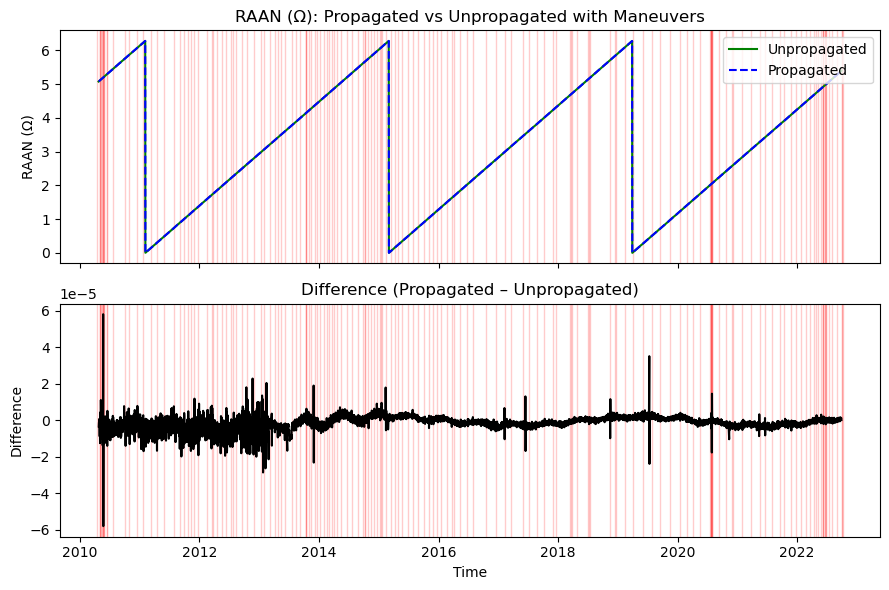

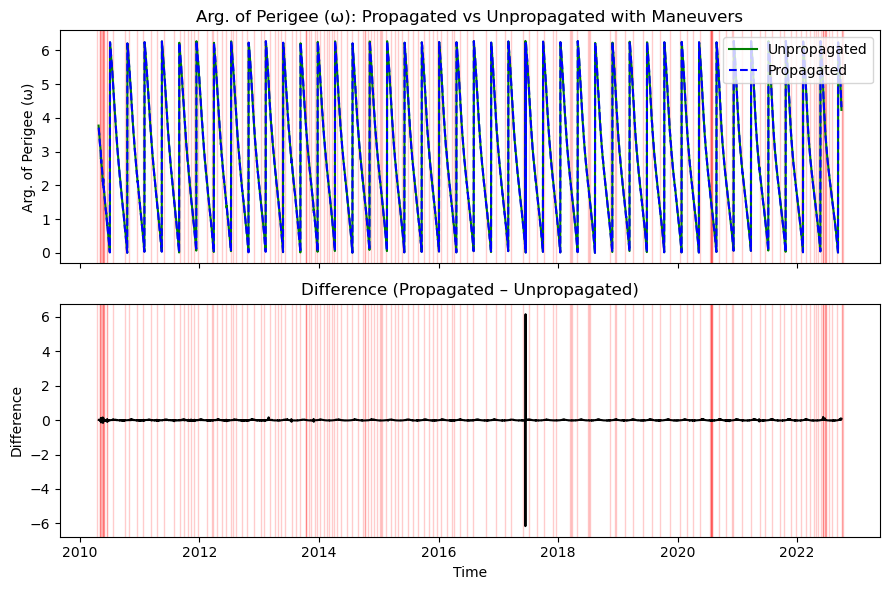

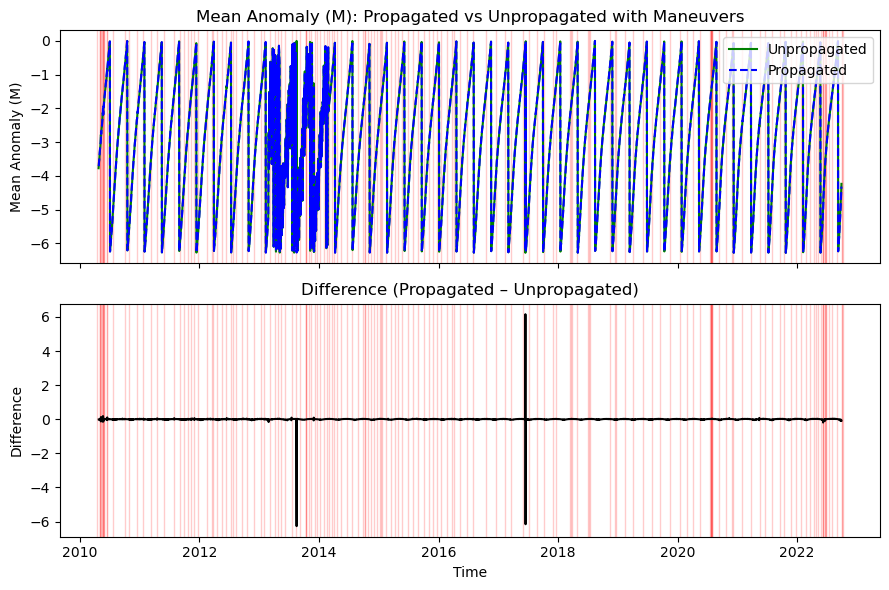

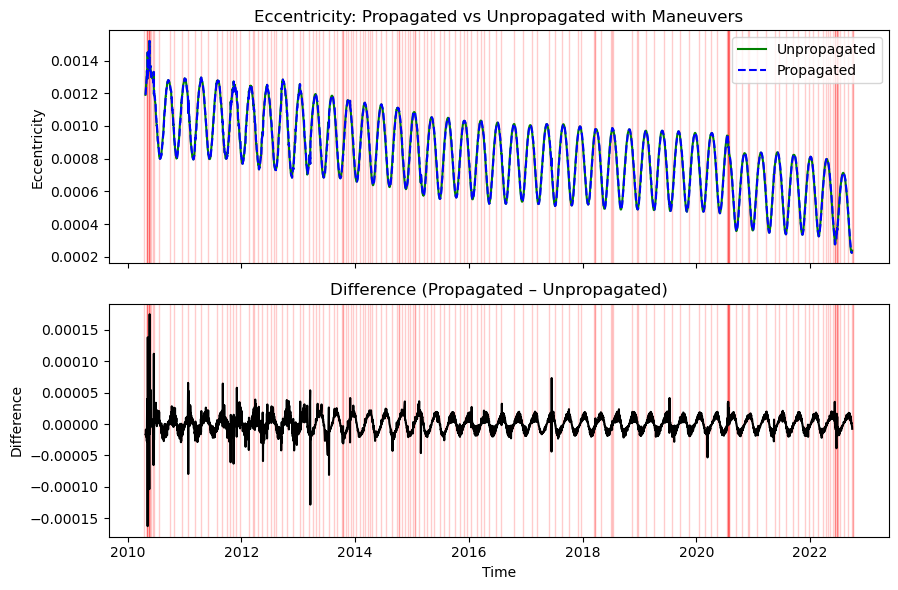

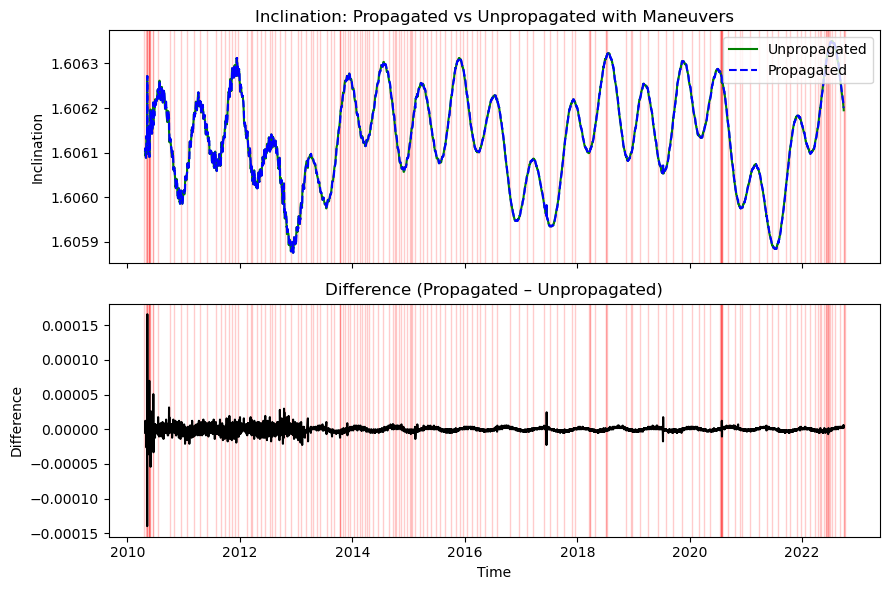

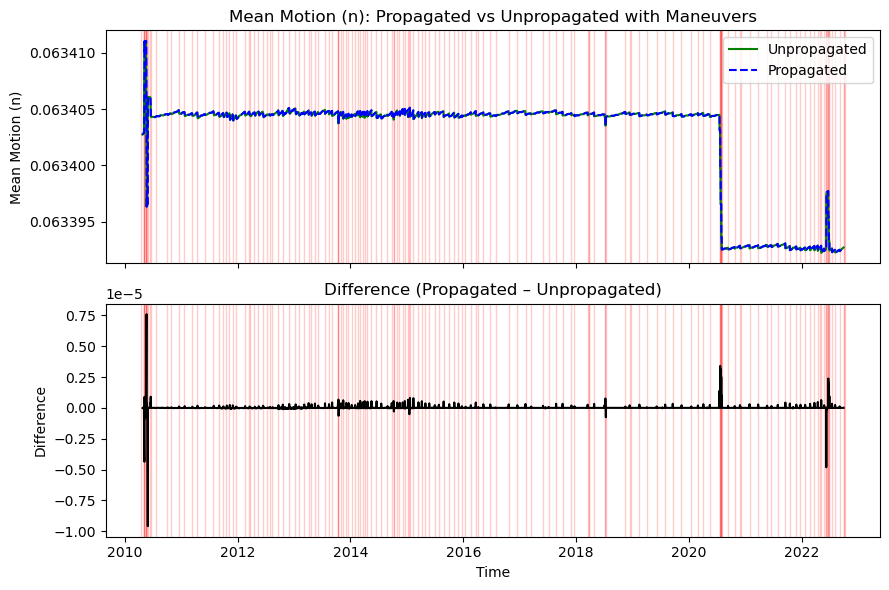

In [3]:
# Path configurations 
orbital_path = "./satellite_data/orbital_elements/"
man_path = "./satellite_data/manoeuvres/"

# Example usage: CryoSat-2
cs2_prop_path = orbital_path + "propagated_elements_CryoSat-2.csv"
cs2_unprop_path = orbital_path + "unpropagated_elements_CryoSat-2.csv"
cs2_maneuvers_path = man_path + "cs2man.txt"
EDA_data(cs2_prop_path, cs2_unprop_path, cs2_maneuvers_path)

## 1.2 Example: Sentinel-3A

Propagated Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2400 entries, 2016-03-05 to 2022-09-29
Freq: D
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   eccentricity         2384 non-null   float64
 1   argument of perigee  2384 non-null   float64
 2   inclination          2384 non-null   float64
 3   mean anomaly         2384 non-null   float64
 4   Brouwer mean motion  2384 non-null   float64
 5   right ascension      2384 non-null   float64
dtypes: float64(6)
memory usage: 131.2 KB
None

Unpropagated Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2401 entries, 2016-03-04 to 2022-09-29
Freq: D
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   eccentricity         2385 non-null   float64
 1   argument of perigee  2385 non-null   float64
 2   inclination          2385 non-null   

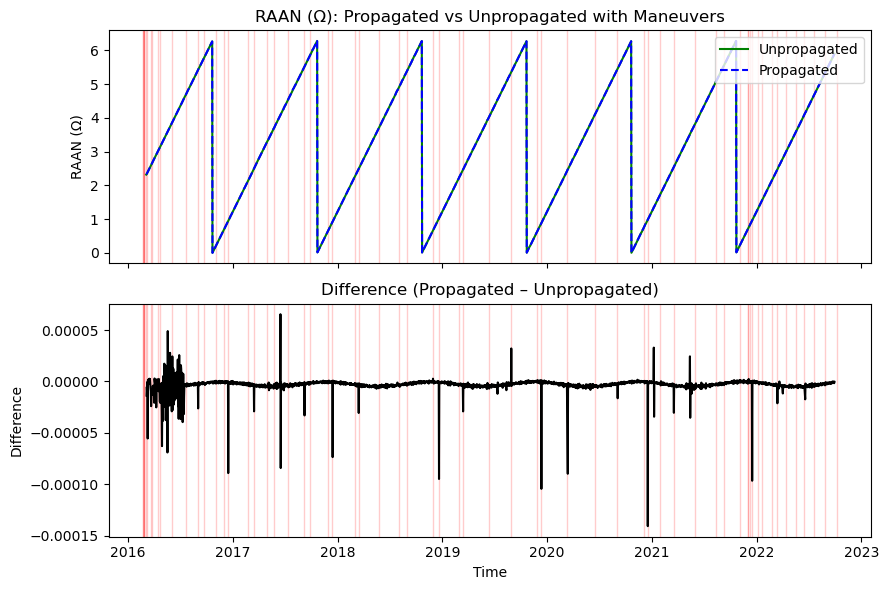

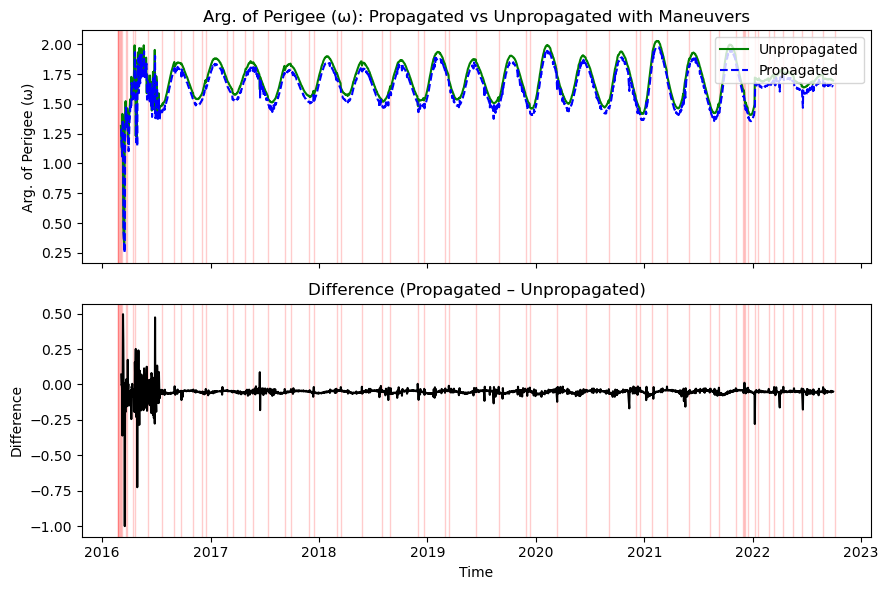

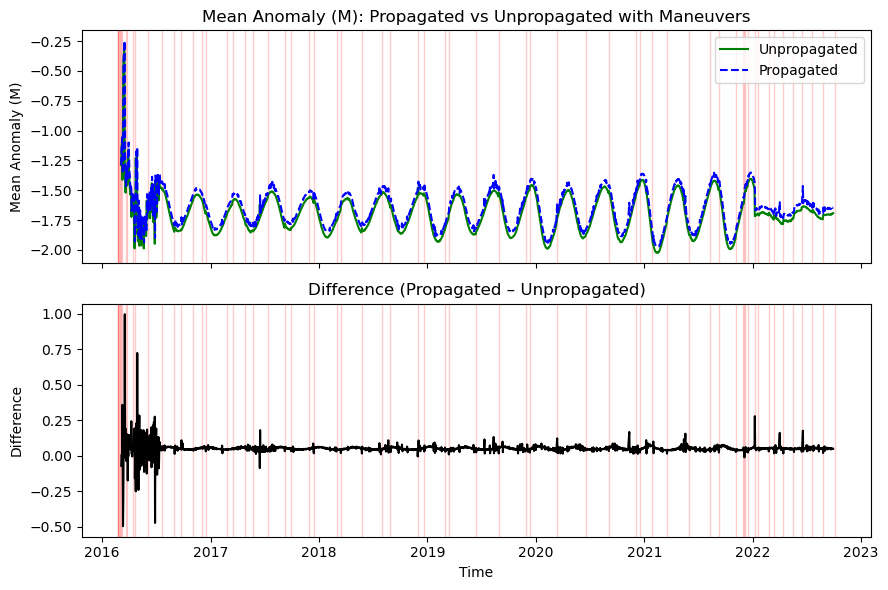

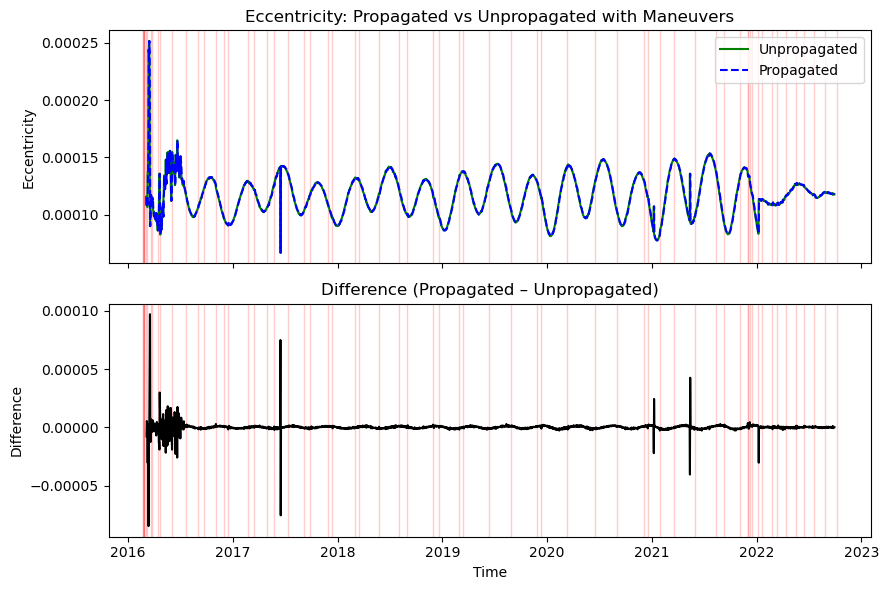

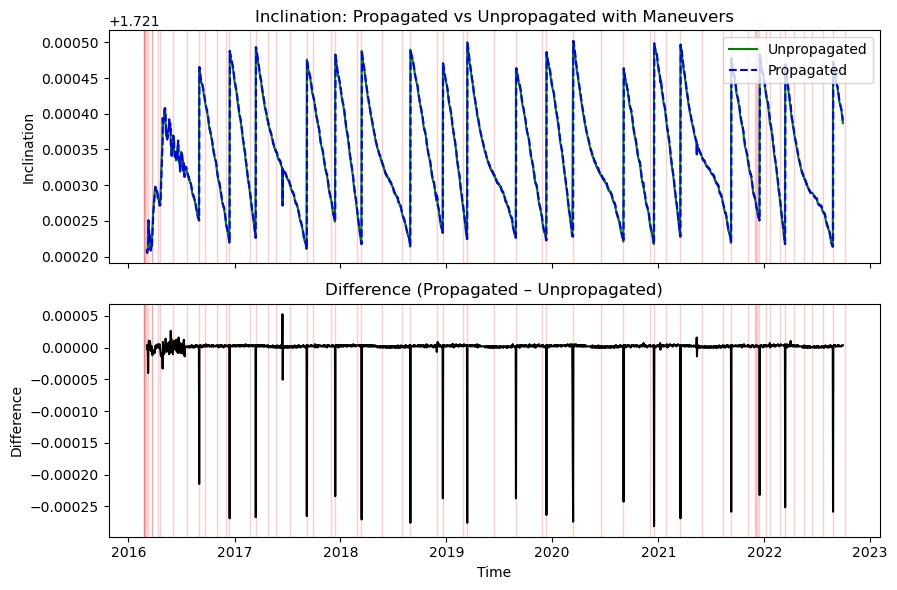

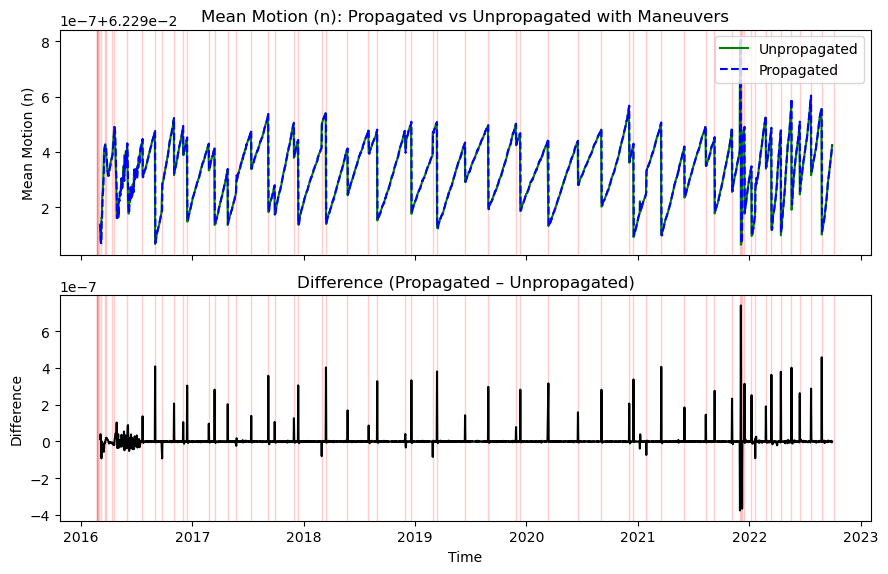

In [4]:
# Example usage: Sentinel-3A
s3a_prop_path = orbital_path + "propagated_elements_Sentinel-3A.csv"
s3a_unprop_path = orbital_path + "unpropagated_elements_Sentinel-3A.csv"
s3a_maneuvers_path = man_path + "s3aman.txt"
EDA_data(s3a_prop_path, s3a_unprop_path, s3a_maneuvers_path)

## 1.3 Example: Sentinel-3B

Propagated Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1603 entries, 2018-05-11 to 2022-09-29
Freq: D
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   eccentricity         1581 non-null   float64
 1   argument of perigee  1581 non-null   float64
 2   inclination          1581 non-null   float64
 3   mean anomaly         1581 non-null   float64
 4   Brouwer mean motion  1581 non-null   float64
 5   right ascension      1581 non-null   float64
dtypes: float64(6)
memory usage: 87.7 KB
None

Unpropagated Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1604 entries, 2018-05-10 to 2022-09-29
Freq: D
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   eccentricity         1582 non-null   float64
 1   argument of perigee  1582 non-null   float64
 2   inclination          1582 non-null   f

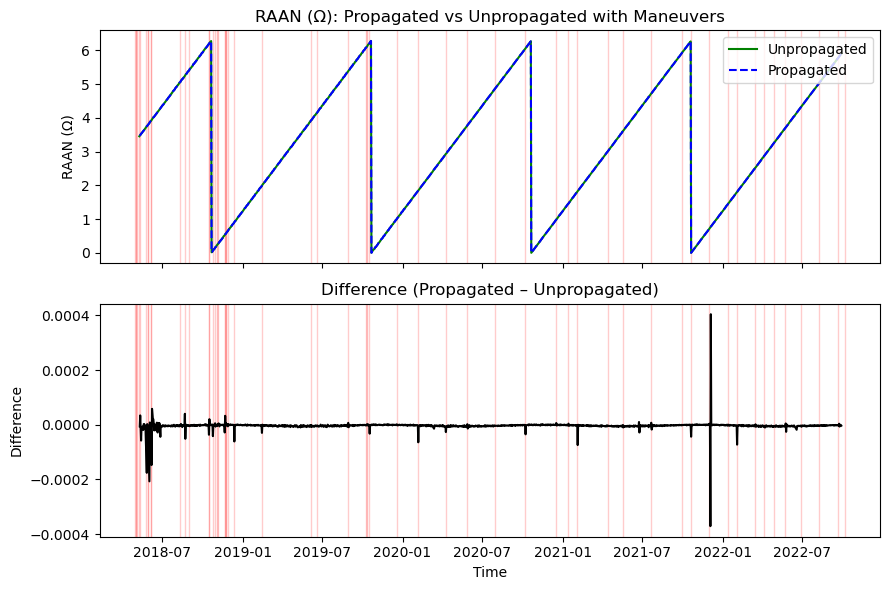

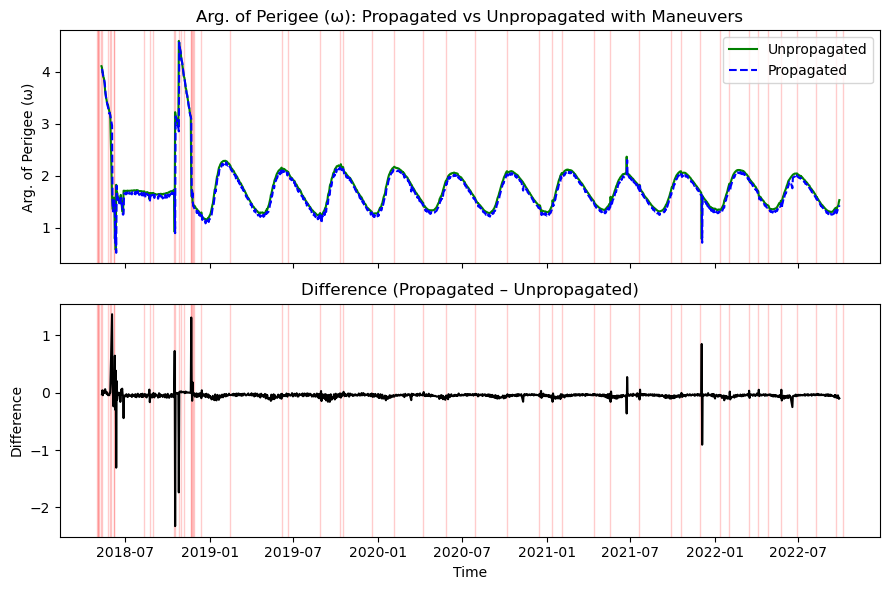

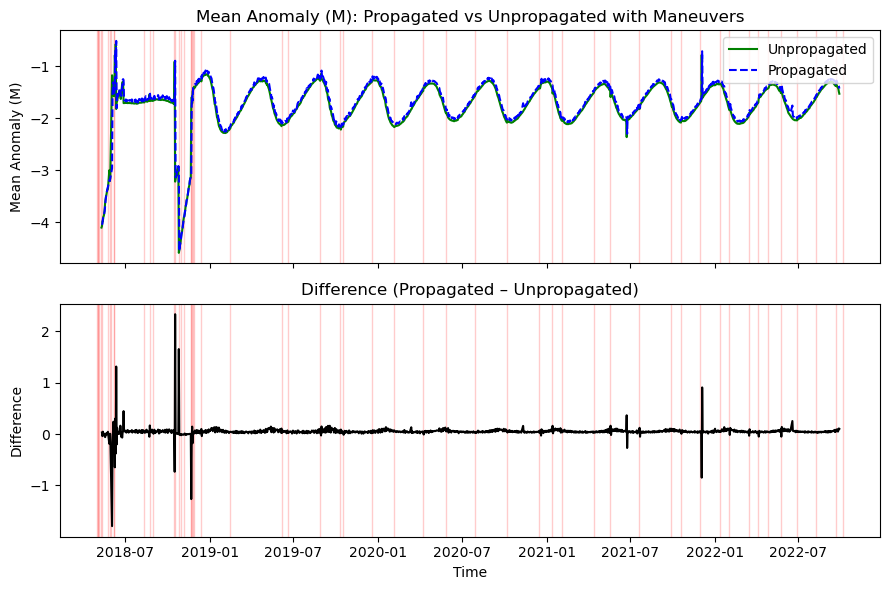

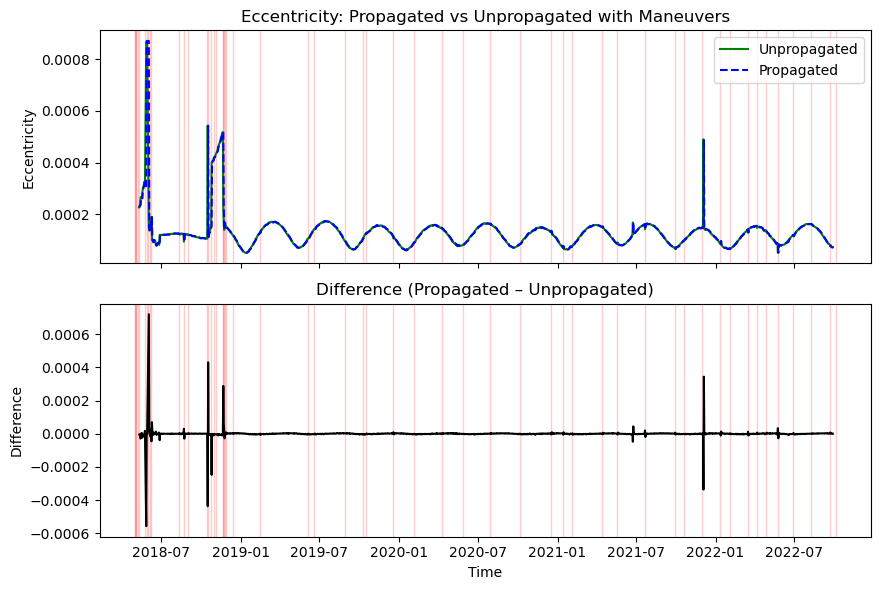

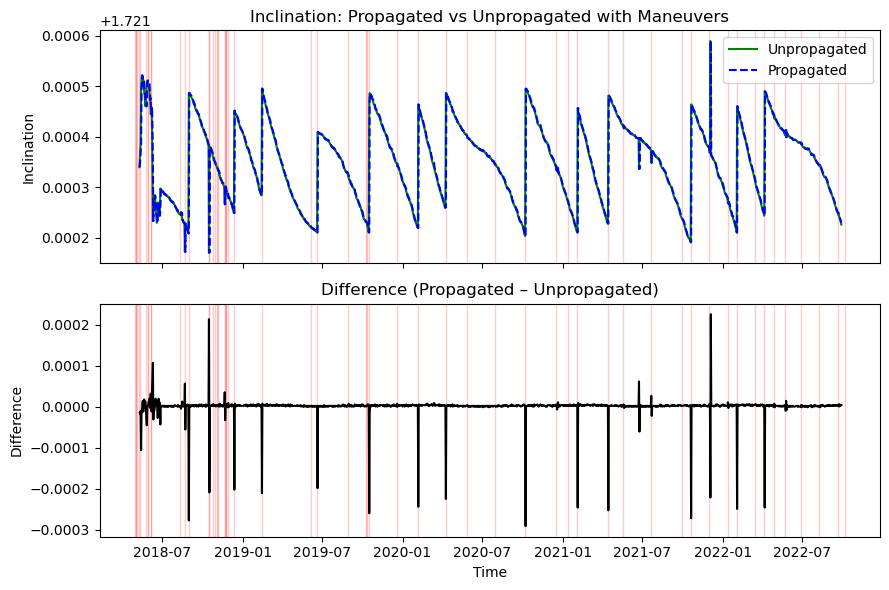

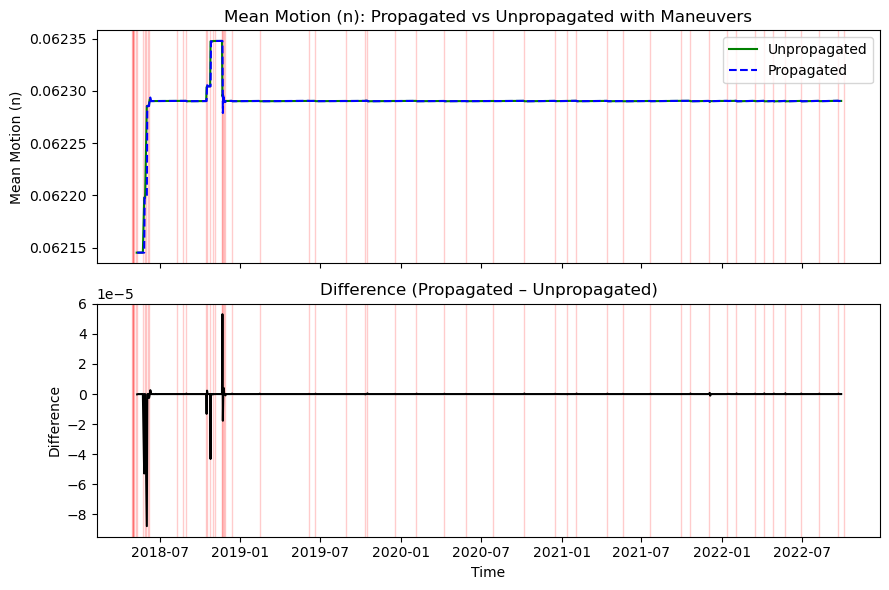

In [80]:
# Example usage: Sentinel-3B
s3b_prop_path = orbital_path + "propagated_elements_Sentinel-3B.csv"
s3b_unprop_path = orbital_path + "unpropagated_elements_Sentinel-3B.csv"
s3b_maneuvers_path = man_path + "s3bman.txt"
EDA_data(s3b_prop_path, s3b_unprop_path, s3b_maneuvers_path)

## 1.4 Example: Jason-1

Propagated Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4184 entries, 2001-12-23 to 2013-06-06
Freq: D
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   eccentricity         3995 non-null   float64
 1   argument of perigee  3995 non-null   float64
 2   inclination          3995 non-null   float64
 3   mean anomaly         3995 non-null   float64
 4   Brouwer mean motion  3995 non-null   float64
 5   right ascension      3995 non-null   float64
dtypes: float64(6)
memory usage: 228.8 KB
None

Unpropagated Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4185 entries, 2001-12-22 to 2013-06-06
Freq: D
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   eccentricity         3996 non-null   float64
 1   argument of perigee  3996 non-null   float64
 2   inclination          3996 non-null   

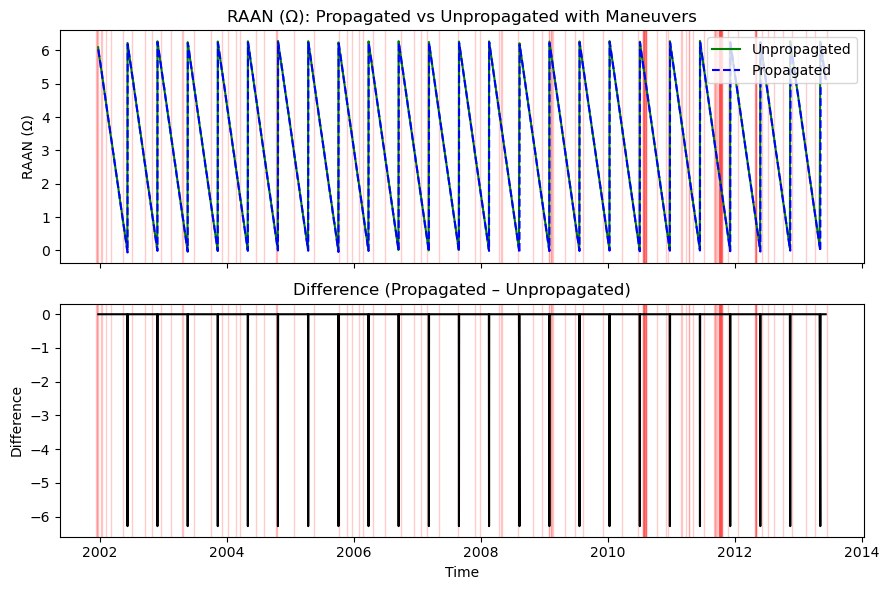

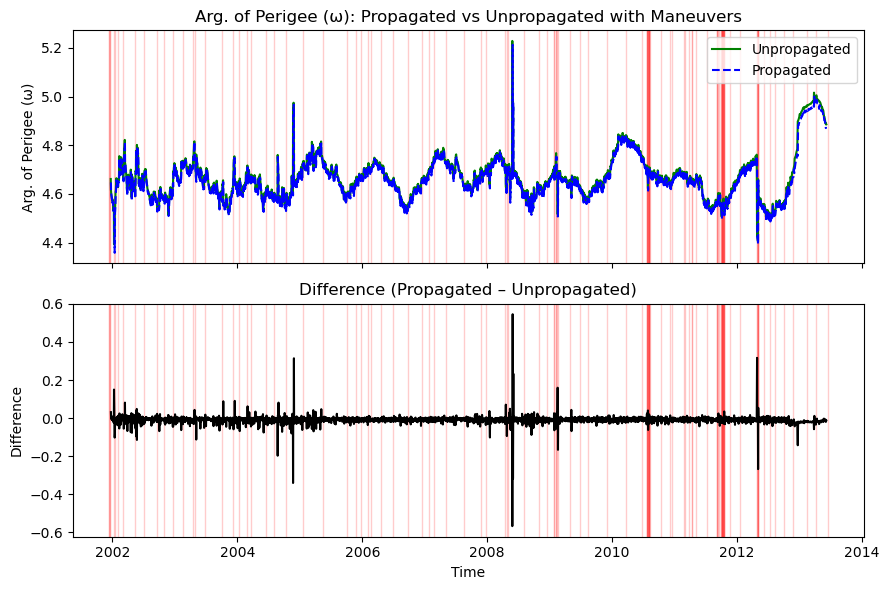

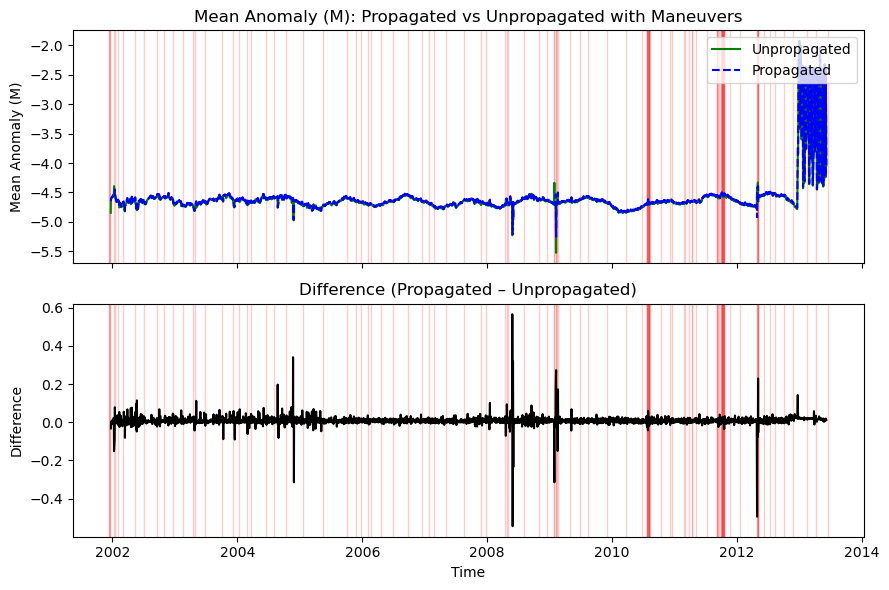

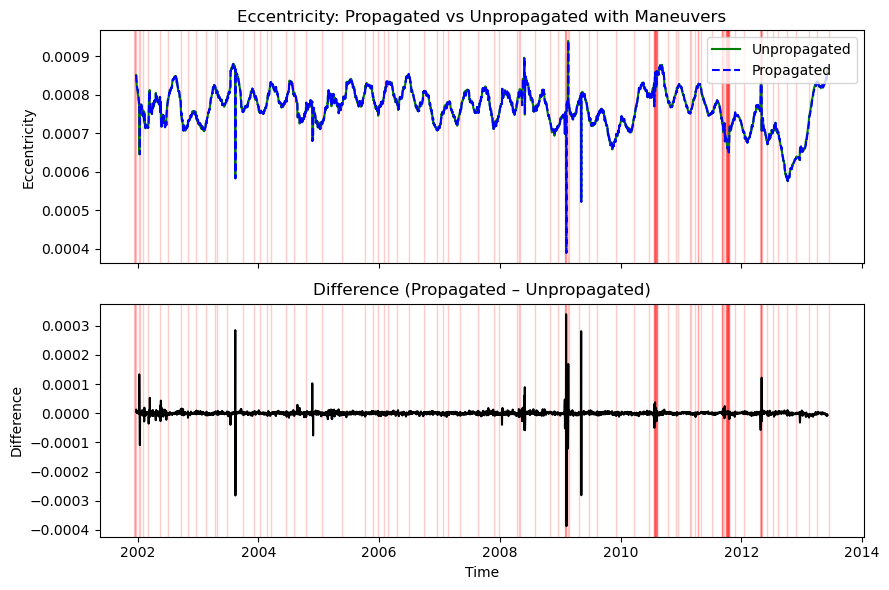

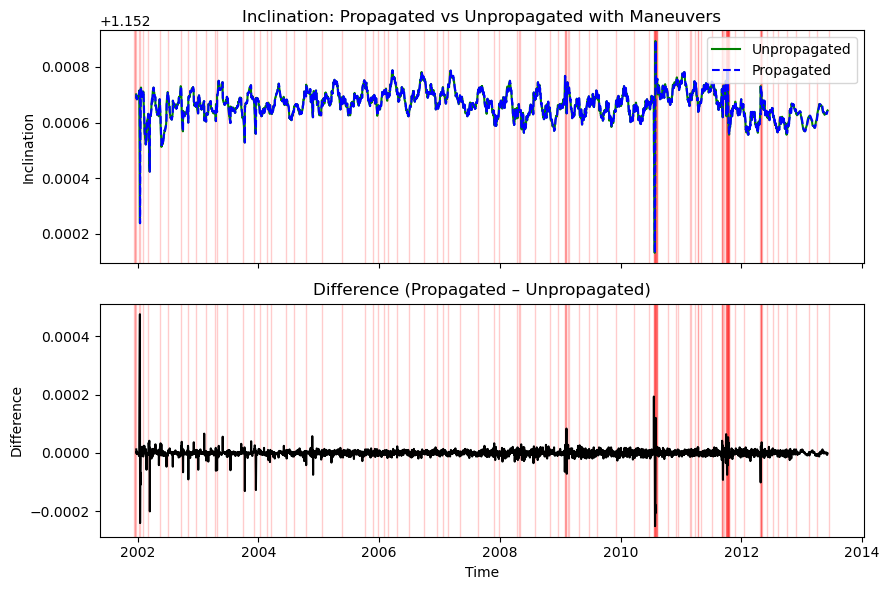

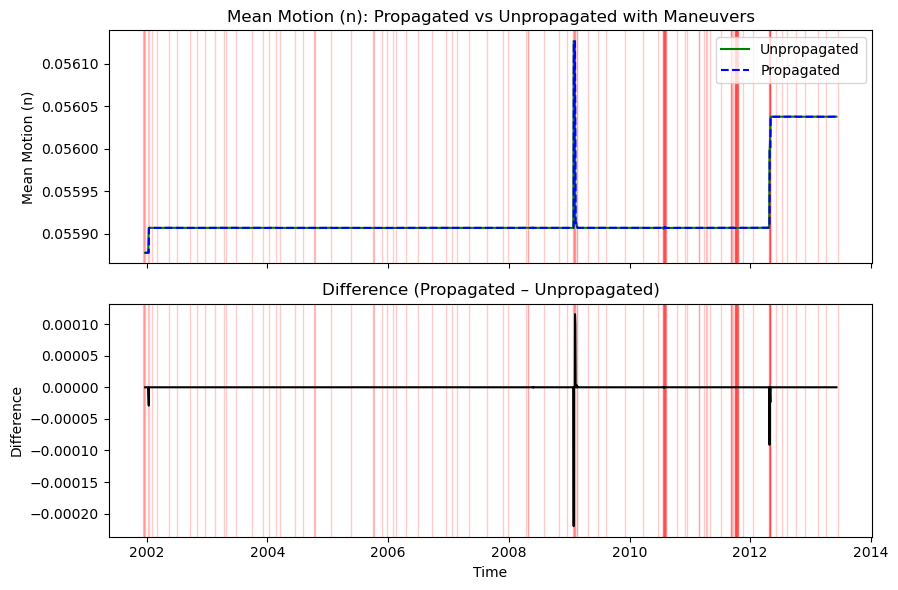

In [ ]:
# Example usage: Jason-1
j1_prop_path = orbital_path + "propagated_elements_Jason-1.csv"
j1_unprop_path = orbital_path + "unpropagated_elements_Jason-1.csv"
j1_maneuvers_path = man_path + "ja1man  .txt"
EDA_data(j1_prop_path, j1_unprop_path, j1_maneuvers_path)

# 2. Data Cleaning

## 2.1 Extract Maneuvers Ground Truth 

In [8]:
def get_maneuvers_dataframe(maneuvers_path):
    # Create maneuvers dataframe, store information
    maneuvers_list = []
    with open(maneuvers_path, 'r') as f:
        for line in f:
            if not line.strip():
                continue

            # --- Parse General Maneuver Info (mostly fixed-width) ---
            sat_id = line[0:5].strip()
            
            # Maneuver Start Time
            y1 = int(line[6:10])
            doy1 = int(line[11:14])
            h1 = int(line[15:17])
            m1 = int(line[18:20])
            start_time = pd.to_datetime(f'{y1}-{doy1}', format='%Y-%j') + pd.Timedelta(hours=h1, minutes=m1)

            # Maneuver End Time
            y2 = int(line[21:25])
            doy2 = int(line[26:29])
            h2 = int(line[30:32])
            m2 = int(line[33:35])
            end_time = pd.to_datetime(f'{y2}-{doy2}', format='%Y-%j') + pd.Timedelta(hours=h2, minutes=m2)

            maneuver_type = line[36:39].strip()
            param_type = line[40:43].strip()
            num_burns = int(line[44])

            # --- Parse Info for Each Burn ---
            burn_data_block = line[46:]
            for i in range(num_burns):
                k = i * 232  # Offset for each burn block

                # Median Burn Time
                burn_y = int(burn_data_block[k+0:k+4])
                burn_doy = int(burn_data_block[k+5:k+8])
                burn_h = int(burn_data_block[k+9:k+11])
                burn_m = int(burn_data_block[k+12:k+14])
                burn_s_ms = float(burn_data_block[k+15:k+21])
                burn_seconds = int(burn_s_ms)
                burn_microseconds = int((burn_s_ms - burn_seconds) * 1e6)
                median_time = pd.to_datetime(f'{burn_y}-{burn_doy}', format='%Y-%j') + \
                            pd.Timedelta(hours=burn_h, minutes=burn_m, seconds=burn_seconds, microseconds=burn_microseconds)

                # Burn parameters
                duration = float(burn_data_block[k+22:k+42])
                dv1 = float(burn_data_block[k+43:k+63])
                dv2 = float(burn_data_block[k+64:k+84])
                dv3 = float(burn_data_block[k+85:k+105])
                acc1 = float(burn_data_block[k+106:k+126])
                acc2 = float(burn_data_block[k+127:k+147])
                acc3 = float(burn_data_block[k+148:k+168])
                delta_acc1 = float(burn_data_block[k+169:k+189])
                delta_acc2 = float(burn_data_block[k+190:k+210])
                delta_acc3 = float(burn_data_block[k+211:k+231])

                maneuvers_list.append({
                    'sat_id': sat_id,
                    'maneuver_start': start_time,
                    'maneuver_end': end_time,
                    'maneuver_type': maneuver_type,
                    'param_type': param_type,
                    'total_burns_in_maneuver': num_burns,
                    'burn_number': i + 1,
                    'burn_median_time': median_time,
                    'burn_duration_sec': duration,
                    'dv_radial': dv1,
                    'dv_along_track': dv2,
                    'dv_cross_track': dv3,
                    'acc_radial_10e-6ms2': acc1,
                    'acc_along_track_10e-6ms2': acc2,
                    'acc_cross_track_10e-6ms2': acc3,
                    'delta_acc_radial_10e-6ms2': delta_acc1,
                    'delta_acc_along_track_10e-6ms2': delta_acc2,
                    'delta_acc_cross_track_10e-6ms2': delta_acc3
                })

    maneuvers_df = pd.DataFrame(maneuvers_list)
    return maneuvers_df

get_maneuvers_dataframe(cs2_maneuvers_path)

,sat_id,maneuver_start,maneuver_end,maneuver_type,param_type,total_burns_in_maneuver,burn_number,burn_median_time,burn_duration_sec,dv_radial,dv_along_track,dv_cross_track,acc_radial_10e-6ms2,acc_along_track_10e-6ms2,acc_cross_track_10e-6ms2,delta_acc_radial_10e-6ms2,delta_acc_along_track_10e-6ms2,delta_acc_cross_track_10e-6ms2
0,CRYO2,2010-04-15 17:47:00,2010-04-15 17:48:00,,006,1,1,2010-04-15 17:47:34.000000,60.0,-7.519838e-05,0.005494,6.573113e-05,-1.253306,91.571266,1.095519e+00,0.0,0.0,0.0
1,CRYO2,2010-05-03 17:55:00,2010-05-04 00:35:00,,006,2,1,2010-05-03 17:56:05.000000,120.0,6.537115e-09,-0.011612,2.718976e-18,0.000054,-96.768215,2.265813e-14,0.0,0.0,0.0
2,CRYO2,2010-05-03 17:55:00,2010-05-04 00:35:00,,006,2,2,2010-05-04 00:32:47.000000,300.0,1.634327e-08,-0.028076,6.733912e-18,0.000054,-93.587521,2.244637e-14,0.0,0.0,0.0
3,CRYO2,2010-05-04 18:38:00,2010-05-04 18:48:00,,006,1,1,2010-05-04 18:43:33.000000,600.0,3.242588e-08,-0.056248,1.353135e-17,0.000054,-93.746442,2.255225e-14,0.0,0.0,0.0
4,CRYO2,2010-05-05 17:44:00,2010-05-05 17:59:00,,006,1,1,2010-05-05 17:51:45.523000,900.0,4.903776e-08,-0.084413,2.039232e-17,0.000054,-93.792645,2.265813e-14,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,CRYO2,2022-08-03 17:18:00,2022-08-03 17:20:00,,006,1,1,2022-08-03 17:19:29.108000,95.0,-1.096608e-04,0.009560,9.585487e-05,-1.154325,100.628240,1.008999e+00,0.0,0.0,0.0
186,CRYO2,2022-09-01 17:13:00,2022-09-01 17:14:00,,006,1,1,2022-09-01 17:14:00.028000,47.0,-5.440512e-05,0.004760,4.755568e-05,-1.157556,101.266489,1.011823e+00,0.0,0.0,0.0
187,CRYO2,2022-09-29 16:20:00,2022-09-29 16:22:00,,006,1,1,2022-09-29 16:21:40.926999,112.0,-1.295534e-04,0.011285,1.132430e-04,-1.156726,100.759010,1.011098e+00,0.0,0.0,0.0
188,CRYO2,2022-10-02 19:36:00,2022-10-02 19:38:00,,006,1,1,2022-10-02 19:37:28.603000,148.0,8.571230e-09,-0.014712,3.572785e-18,0.000058,-99.406908,2.414044e-14,0.0,0.0,0.0


## 2.2 Add Maneuvers Status to The Unpropagate Data

In [11]:
# Add Maneuvers Status to The Unpropagate Data (no maneuver, during maneuver, after maneuver)
def add_maneuver_status(unprop_data, maneuvers_df):
    
    # Initialize maneuver status column
    unprop_data['maneuver_status'] = 0

    for _, maneuver in maneuvers_df.iterrows():
        median_time = maneuver['burn_median_time']
        after_median_indices = unprop_data.index[unprop_data.index >= median_time]
        
        # Mark first dates after the maneuver as 1 
        if not after_median_indices.empty:
            first_date_after = after_median_indices[0]
            unprop_data.loc[first_date_after, 'maneuver_status'] = 1

    return unprop_data
    

## 2.3 Unique Time Interval and Fill Missing Date 

In [12]:
def preprocess_data(unprop_with_status):
    unprop_data = unprop_with_status.copy()
    # Remove the time part from the index for daily frequency
    unprop_data.index = unprop_data.index.normalize()
    # Create a full date range to identify missing days
    full_date_range = pd.date_range(start=unprop_data.index.min(), end=unprop_data.index.max(), freq='D')
    unprop_data = unprop_data.reindex(full_date_range)
    # Fill missing maneuver status with 0 (no maneuver)
    unprop_data['maneuver_status'] = unprop_data['maneuver_status'].fillna(0)
    # Fill other missing values with interpolation
    unprop_data = unprop_data.interpolate(method='time')
    return unprop_data

In [13]:
# Read unpropagated data and maneuvers data
cs2_unprop = pd.read_csv(cs2_unprop_path, parse_dates=[0], index_col=0)
unprop_data = add_maneuver_status(cs2_unprop, get_maneuvers_dataframe(cs2_maneuvers_path))

cs2_unprop = preprocess_data(unprop_data)
cs2_unprop.describe()

,eccentricity,argument of perigee,inclination,mean anomaly,Brouwer mean motion,right ascension,maneuver_status
count,4540.000000,4540.000000,4540.000000,4540.000000,4540.000000,4540.000000,4540.000000
mean,0.000827,2.820575,1.606133,-2.821146,0.063402,3.176159,0.034802
std,0.000232,1.782337,0.000105,1.797963,0.000005,1.817968,0.183298
min,0.000224,0.003416,1.605876,-6.279445,0.063392,0.001339,0.000000
25%,0.000658,1.330437,1.606066,-4.271533,0.063404,1.599253,0.000000
50%,0.000824,2.558517,1.606134,-2.548961,0.063404,3.195521,0.000000
75%,0.000986,4.244834,1.606216,-1.309612,0.063405,4.789594,0.000000
max,0.001520,6.281550,1.606350,-0.001040,0.063411,6.281080,1.000000


In [14]:
# Check for duplicated dates again
cs2_unprop.index.has_duplicates

False

# 3. Feature Engineering

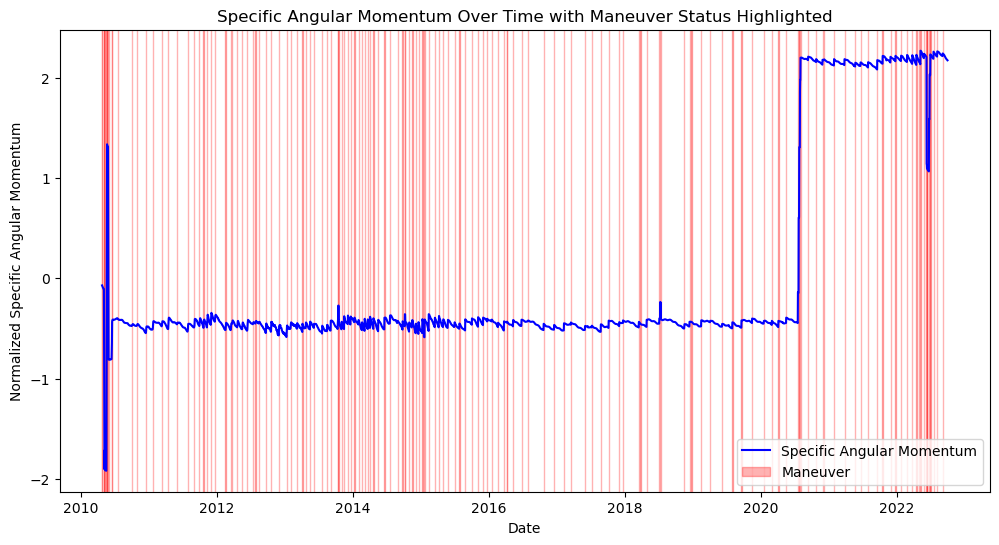

In [15]:
# Select features and normalize
def select_and_normalize_features(unprop_data):
    # Create new feature h = sqrt(mu*a(1-eccentricity^2)), a = (mu/n)^(1/3)
    mu = 398600.4418  # Earth's gravitational parameter in km^3/s^2
    # The 'Brouwer mean motion' is given in revolutions per day.
    # Convert revolutions per day to radians per second for the formula.
    n_rev_per_day = unprop_data["Brouwer mean motion"]
    n_rad_per_sec = n_rev_per_day * (2 * np.pi) / 86400
    
    # Calculate semi-major axis 'a' in km
    a = (mu / n_rad_per_sec**2)**(1/3)
    
    e = unprop_data["eccentricity"]
    # Ensure the argument of sqrt is non-negative to avoid warnings
    unprop_data["specific_angular_momentum"] = np.sqrt(mu * a * np.maximum(0, 1 - e**2))
    
    # Select features and normalize
    scaler = StandardScaler()
    features = ["inclination", "specific_angular_momentum", "Brouwer mean motion"]
    unprop_data[features] = scaler.fit_transform(unprop_data[features])
    
    return unprop_data[["inclination", "Brouwer mean motion", "specific_angular_momentum", "maneuver_status"]]

cs2_unprop_normalized = select_and_normalize_features(cs2_unprop.copy())

# plot the specific_angular_momentum with maneuver status as the time series
plt.figure(figsize=(12, 6))
plt.plot(cs2_unprop_normalized.index, cs2_unprop_normalized['specific_angular_momentum'], label='Specific Angular Momentum', color='blue')
# Highlight maneuver status
maneuver_dates = cs2_unprop_normalized[cs2_unprop_normalized['maneuver_status'] == 1].index
for date in maneuver_dates:
    plt.axvspan(date, date + pd.Timedelta(days=1), color='red', alpha=0.3, label='_nolegend_')

# Create a single legend entry for maneuvers
if not maneuver_dates.empty:
    plt.axvspan(maneuver_dates[0], maneuver_dates[0] + pd.Timedelta(days=1), color='red', alpha=0.3, label='Maneuver')

plt.title('Specific Angular Momentum Over Time with Maneuver Status Highlighted')
plt.xlabel('Date')
plt.ylabel('Normalized Specific Angular Momentum')
plt.legend()
plt.show()


In [ ]:
# plot difference between propagated and unpropagated specific_angular_momentum
